In [67]:
from sberpm import DataHolder
from sberpm.miners import SimpleMiner, CausalMiner, HeuMiner,\
                          AlphaMiner, AlphaPlusMiner,\
                          InductiveMiner, CorrelationMiner
from sberpm.metrics import ActivityMetric, TransitionMetric, IdMetric,\
                           TraceMetric, UserMetric
from sberpm.ml.chronometrage import Chronometrage
from sberpm.visual import GraphvizPainter, ChartPainter

import pandas as pd

### DataHolder

In [3]:
dh = DataHolder(data = 'sample_data/example.csv',
                id_column = 'id',
                activity_column = 'stages',
                start_timestamp_column = 'dt',
                user_column = 'users',
                time_format = '%Y-%m-%d')

In [4]:
dh.data.head()

,id,stages,dt,users
0,0.0,Stage_0,2019-12-01,Oliver
1,0.0,Stage_3,2019-12-02,Liam
2,0.0,Stage_5,2019-12-05,Emma
3,0.0,Stage_2,2019-12-11,Patricia
4,0.0,Stage_7,2019-12-17,Callum


In [8]:
# рассчитывает длительность каждой активности (в секундах), если это необходимо
dh.check_or_calc_duration()

In [9]:
#выводит сгруппированные данные по id и указанным колонкам
dh.get_grouped_data(dh.activity_column, dh.start_timestamp_column).head()

,id,stages,dt
0,0.0,"(Stage_0, Stage_3, Stage_5, Stage_2, Stage_7)","(2019-12-01 00:00:00, 2019-12-02 00:00:00, 201..."
1,1.0,"(Stage_0, Stage_2, Stage_4, Stage_3, Stage_8)","(2019-12-01 00:00:00, 2019-12-06 00:00:00, 201..."
2,10.0,"(Stage_0, Stage_2, Stage_5, Stage_7)","(2019-12-01 00:00:00, 2019-12-06 00:00:00, 201..."
3,100.0,"(Stage_2, Stage_3, Stage_8)","(2019-12-01 00:00:00, 2019-12-09 00:00:00, 201..."
4,101.0,"(Stage_0, Stage_2, Stage_5, Stage_3, Stage_7, ...","(2019-12-01 00:00:00, 2019-12-10 00:00:00, 201..."


In [10]:
dh_5 = dh.top_traces_dh(5)  # данные только для топ 5 цепочек
dfg = dh_5.get_grouped_data(dh_5.activity_column)
dfg.value_counts(dh_5.activity_column)  # проверка

,0
stages,
"(Stage_0, Stage_2, Stage_3, Stage_5, Stage_8)",12
"(Stage_0, Stage_2, Stage_3, Stage_8)",12
"(Stage_0, Stage_2, Stage_5)",11
"(Stage_0, Stage_2, Stage_3, Stage_5)",10
"(Stage_0, Stage_2, Stage_3, Stage_5, Stage_7, Stage_8)",10


### Miners

SimpleMiner отрисовывает все ребра, найденные в логе (без какой-либо фильтрации)

In [12]:
# Создание объекта SimpleMiner. В конструктор подается DataHolder и параметры алгоритма
simple_miner = SimpleMiner(dh)
simple_miner.apply() # Запуск алгоритма построения графа

graph = simple_miner.graph # Сохранение графа

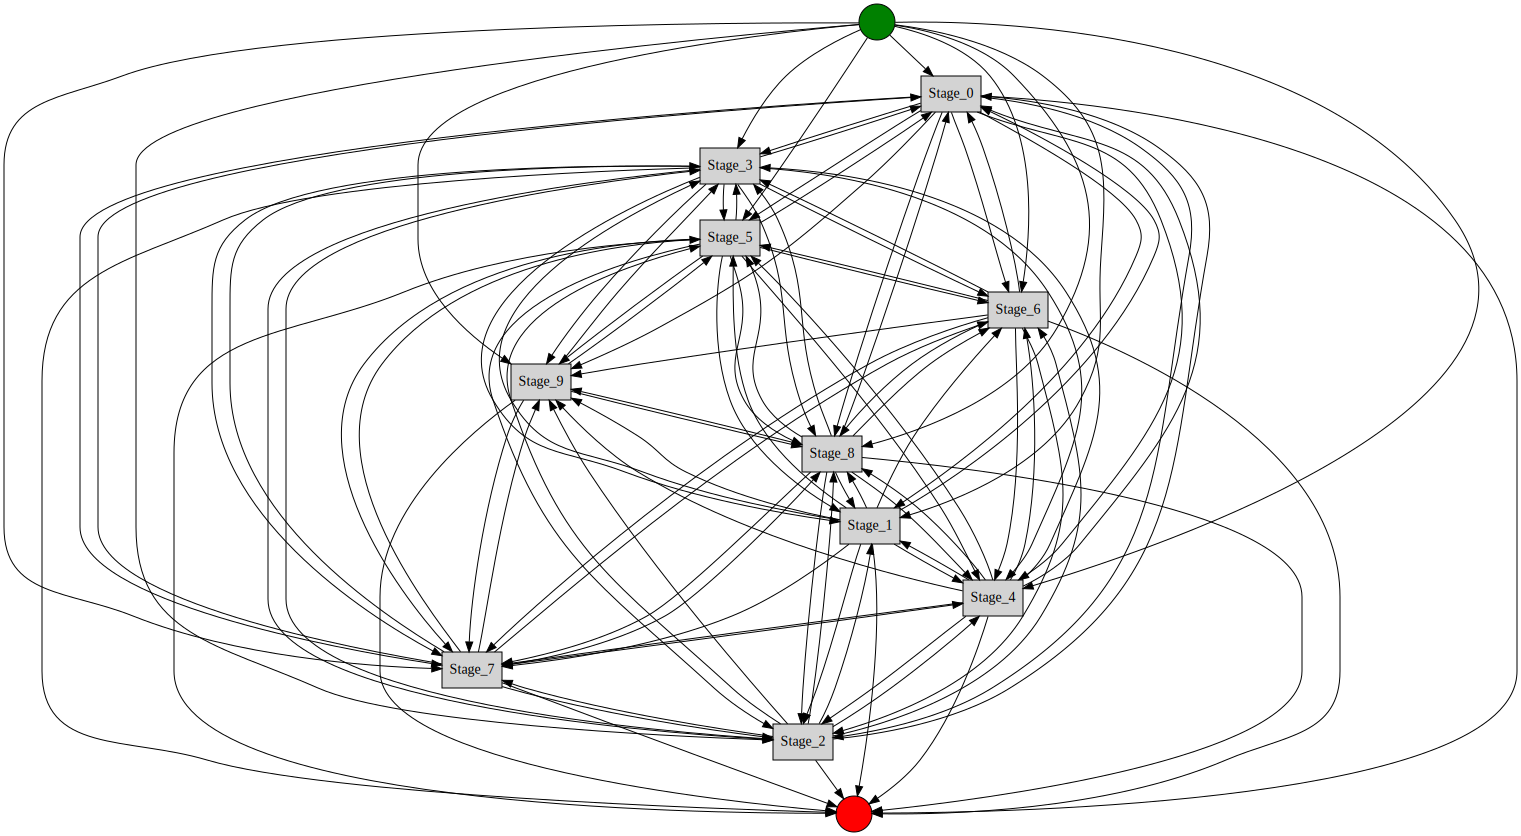

In [18]:
# Создание объекта GraphvizPainter
painter = GraphvizPainter()

painter.apply(graph) # Расчет графа по результатам работы SimpleMiner
painter.show()

#painter.write_graph('SimpleMiner.png', format='png') - сохранить граф на жесткий диск в формате png, svg, pdf или gv

CausalMiner основан на фильтрации ребер

In [20]:
causal_miner = CausalMiner(dh)
causal_miner.apply()
graph = causal_miner.graph

painter.apply(graph)
painter.show()

HeuMiner – это эвристический майнер, который удаляет наиболее редкие связи в зависимости от задаваемого порога (threshold)

Параметр threshold принимает значения от 0 до 1. Чем он больше, тем меньше ребер на графе (оставшиеся ребра считаются более важными)

In [22]:
heu_miner = HeuMiner(dh, threshold = 0.8)
heu_miner.apply()
graph = heu_miner.graph

painter.apply(graph)
painter.show()

In [24]:
heu_miner = HeuMiner(dh, threshold = 1)
heu_miner.apply()
graph = heu_miner.graph

painter.apply(graph)
painter.show()

In [25]:
heu_miner = HeuMiner(dh, threshold = 0)
heu_miner.apply()
graph = heu_miner.graph

painter.apply(graph)
painter.show()


AlphaMiner рисует граф в виде сетей Петри с учетом прямых, параллельных и независимых связей между активностями.

In [28]:
alpha_miner = AlphaMiner(dh)
alpha_miner.apply()
graph = alpha_miner.graph

painter.apply(graph)
painter.show()

AlphaPlusMiner – имплементация Alpha+ майнера, который также рисует граф в виде сетей Петри с учетом связей, но в отличие от AlphaMiner может работать с одноцикловыми (one-loop) цепочками вида activity_1
activity_1 (самоцикл)

In [31]:
alpha_miner_plus = AlphaPlusMiner(dh)
alpha_miner_plus.apply()
graph = alpha_miner_plus.graph

painter.apply(graph)
painter.show()


InductiveMiner создаёт дерево процесса. Листья дерева - реальные активности процесса, остальные вершины - операторы

In [34]:
inductive_miner = InductiveMiner(dh)
inductive_miner.apply()
graph = inductive_miner.graph

painter.apply(graph)
painter.show()

In [35]:
inductive_miner = InductiveMiner(dh, parallel_activity = False)
inductive_miner.apply()
graph = inductive_miner.graph

painter.apply(graph)
painter.show()

Correlation-miner может создать граф журнала событий, в котором нет графы ID экземпляра процесса


Correlation-miner использует линейное программирование, чтобы восстановить утраченные экземпляры процесса на основе времени каждого этапа

In [38]:
corr_miner = CorrelationMiner(dh)
corr_miner.apply()
graph = corr_miner.graph

painter.apply(graph)
painter.show()

### Метрики

1. ActivityMetric – метрики по активностям (группировка по activity_column)
2. TransitionMetric – метрики по переходам (группировка по уникальным переходам)
3. IdMetric– метрики по id (группировка по id_column)
4. TraceMetric – метрики по цепочкам активностей (группировка по уникальным цепочкам)
5. UserMetric – метрики по пользователям (группировка по user_column)

In [42]:
activity_metric = ActivityMetric(dh, time_unit='d')
transition_metric = TransitionMetric(dh, time_unit='d')
id_metric = IdMetric(dh, time_unit='d')
trace_metric = TraceMetric(dh, time_unit='d')
user_metric = UserMetric(dh, time_unit='d')

In [43]:
activity_metric.apply().head()

,count,unique_ids,unique_ids_num,aver_count_in_trace,loop_percent,throughput,unique_users,unique_users_num,total_duration,mean_duration,median_duration,max_duration,min_duration,variance_duration,std_duration
Stage_0,758,"{423.0, 811.0, 453.0, 590.0, 360.0, 113.0, 267...",758,1.0,0.0,0.200053,"{Jake, Oliver}",2,3789.0,5.079088,5.0,9.0,1.0,568935.172394,2.566106
Stage_2,672,"{423.0, 272.0, 590.0, 360.0, 267.0, 445.0, 157...",672,1.0,0.0,0.203575,"{Patricia, Olivia, Mason}",3,3301.0,5.070661,5.0,9.0,1.0,556191.654102,2.537204
Stage_8,633,"{423.0, 811.0, 272.0, 445.0, 785.0, 198.0, 259...",633,1.0,0.0,0.595484,"{Isabella, Mary}",2,1063.0,5.288557,6.0,9.0,1.0,555910.358654,2.536562
Stage_5,613,"{811.0, 590.0, 267.0, 445.0, 785.0, 157.0, 198...",613,1.0,0.0,0.245396,"{Margaret, Emma}",2,2498.0,4.976096,5.0,9.0,1.0,580655.011825,2.592401
Stage_3,577,"{453.0, 272.0, 590.0, 113.0, 267.0, 445.0, 516...",577,1.0,0.0,0.211821,"{Noah, Liam, Amelia}",3,2724.0,5.082090,5.0,9.0,1.0,573913.299176,2.577308


In [44]:
transition_metric.apply().head()

,count,unique_ids,unique_ids_num,aver_count_in_trace,loop_percent,throughput,unique_users,unique_users_num,total_duration,mean_duration,median_duration,max_duration,min_duration,variance_duration,std_duration
"(Stage_0, Stage_2)",313,"{360.0, 267.0, 91.0, 320.0, 220.0, 308.0, 747....",313,1.0,0.0,0.193210,"{Jake, Oliver}",2,1620.0,5.175719,5.0,9.0,1.0,572320.076759,2.573728
"(Stage_2, Stage_3)",242,"{578.0, 46.0, 272.0, 267.0, 445.0, 168.0, 596....",242,1.0,0.0,0.200165,"{Mason, Olivia, Patricia}",3,1209.0,4.995868,5.0,9.0,1.0,526610.094939,2.468810
"(Stage_7, Stage_8)",219,"{423.0, 536.0, 740.0, 811.0, 142.0, 578.0, 46....",219,1.0,0.0,0.198370,"{Harry, Callum}",2,1104.0,5.041096,5.0,9.0,1.0,605443.122537,2.647158
"(Stage_3, Stage_5)",184,"{983.0, 756.0, 810.0, 267.0, 445.0, 620.0, 564...",184,1.0,0.0,0.195329,"{Noah, Liam, Amelia}",3,942.0,5.119565,5.0,9.0,1.0,579147.448015,2.589034
"(Stage_5, Stage_7)",178,"{811.0, 756.0, 46.0, 810.0, 982.0, 445.0, 620....",178,1.0,0.0,0.199105,"{Margaret, Emma}",2,894.0,5.022472,5.0,9.0,1.0,544567.605100,2.510551


In [45]:
id_metric.apply().head()

,trace,trace_length,unique_activities,unique_activities_num,loop_percent,unique_users,unique_users_num,total_duration,mean_duration,median_duration,max_duration,min_duration,variance_duration,std_duration
0.0,"(Stage_0, Stage_3, Stage_5, Stage_2, Stage_7)",5,"{Stage_0, Stage_5, Stage_7, Stage_3, Stage_2}",5,0.0,"{Patricia, Oliver, Callum, Liam, Emma}",5,16.0,4.000000,4.5,6.0,1.0,388800.0,2.121320
1.0,"(Stage_0, Stage_2, Stage_4, Stage_3, Stage_8)",5,"{Stage_0, Stage_8, Stage_4, Stage_3, Stage_2}",5,0.0,"{William, Isabella, Jake, Noah, Olivia}",5,15.0,3.750000,4.0,5.0,2.0,145800.0,1.299038
10.0,"(Stage_0, Stage_2, Stage_5, Stage_7)",4,"{Stage_0, Stage_7, Stage_2, Stage_5}",4,0.0,"{Mason, Oliver, Emma, Harry}",4,16.0,5.333333,5.0,8.0,3.0,364800.0,2.054805
100.0,"(Stage_2, Stage_3, Stage_8)",3,"{Stage_8, Stage_3, Stage_2}",3,0.0,"{Mason, Isabella, Liam}",3,17.0,8.500000,8.5,9.0,8.0,21600.0,0.500000
101.0,"(Stage_0, Stage_2, Stage_5, Stage_3, Stage_7, ...",7,"{Stage_0, Stage_5, Stage_8, Stage_7, Stage_3, ...",7,0.0,"{Barbara, Harry, Margaret, Jake, Liam, Mason, ...",7,26.0,4.333333,4.0,9.0,1.0,854400.0,3.144660


In [46]:
trace_metric.apply().head()

,count,ids,trace_length,unique_activities_num,loop_percent,unique_users,unique_users_num,total_duration,mean_duration,median_duration,max_duration,min_duration,variance_duration,std_duration
"(Stage_0, Stage_2, Stage_3, Stage_8)",12,"{652.0, 463.0, 228.0, 434.0, 832.0, 276.0, 833...",4,4,0.0,"{Patricia, Oliver, Amelia, Mason, Isabella, Ja...",10,196.0,16.333333,18.0,25.0,8.0,2.035200e+06,4.853407
"(Stage_0, Stage_2, Stage_3, Stage_5, Stage_8)",12,"{211.0, 139.0, 193.0, 158.0, 81.0, 20.0, 124.0...",5,5,0.0,"{Patricia, Oliver, Amelia, Noah, Margaret, Isa...",11,247.0,20.583333,20.5,32.0,12.0,2.296200e+06,5.155229
"(Stage_0, Stage_2, Stage_5)",11,"{814.0, 457.0, 73.0, 645.0, 792.0, 565.0, 600....",3,3,0.0,"{Patricia, Oliver, Margaret, Jake, Emma, Mason...",7,129.0,11.727273,10.0,18.0,6.0,1.006810e+06,3.413633
"(Stage_0, Stage_2, Stage_3, Stage_5, Stage_7, Stage_8)",10,"{770.0, 790.0, 361.0, 227.0, 478.0, 349.0, 738...",6,6,0.0,"{Patricia, Oliver, Amelia, Harry, Callum, Marg...",14,252.0,25.200000,26.0,32.0,16.0,1.931904e+06,4.728636
"(Stage_0, Stage_2, Stage_3, Stage_5)",10,"{267.0, 231.0, 981.0, 564.0, 225.0, 924.0, 261...",4,4,0.0,"{Patricia, Oliver, Amelia, Noah, Margaret, Lia...",9,161.0,16.100000,14.5,25.0,11.0,1.649376e+06,4.369210


In [47]:
user_metric.apply().head()

,count,unique_activities,unique_activities_num,unique_ids,unique_ids_num,throughput,workload,total_duration,mean_duration,median_duration,max_duration,min_duration,variance_duration,std_duration
Oliver,493,{Stage_0},1,"{423.0, 590.0, 360.0, 113.0, 267.0, 785.0, 516...",493,0.195093,0.110513,2527.0,5.199588,5.0,9.0,1.0,572380.429813,2.573864
Isabella,427,{Stage_8},1,"{423.0, 811.0, 445.0, 198.0, 259.0, 765.0, 795...",427,0.610000,0.095718,700.0,5.303030,6.0,9.0,1.0,544502.479339,2.510401
Emma,415,{Stage_5},1,"{811.0, 267.0, 785.0, 157.0, 198.0, 308.0, 116...",415,0.242974,0.093028,1708.0,4.936416,5.0,9.0,1.0,596459.941862,2.627446
Harry,328,{Stage_7},1,"{811.0, 590.0, 445.0, 157.0, 765.0, 308.0, 197...",328,0.303142,0.073526,1082.0,4.852018,5.0,9.0,1.0,617630.823061,2.673669
Jake,265,{Stage_0},1,"{303.0, 536.0, 740.0, 811.0, 453.0, 217.0, 229...",265,0.209984,0.059404,1262.0,4.853846,5.0,9.0,1.0,555766.721893,2.536234


### Добавление метрик на граф

В библиотеке реализована возможность представить ряд метрик на графе

Сделать это можно в классе Graph с помощью методов:

* add_node_metric – добавить метрику, связанную с узлами графа
* add_edge_metric – добавить метрику, связанную с ребрами графа

In [52]:
# Расчет метрик
nodes_count_metric = activity_metric.count().to_dict()
edges_count_metric = transition_metric.count().to_dict()
mean_time_node_metric = activity_metric.mean_duration().fillna(0).to_dict()

# Получение графа из майнера
graph = causal_miner.graph

# Добавление метрик на граф
graph.add_node_metric('count', nodes_count_metric)
graph.add_edge_metric('count', edges_count_metric)
graph.add_node_metric('mean_time', mean_time_node_metric)

In [53]:
# Отрисовать граф и связать цвет узлов и ребер с нужными метриками
painter.apply(graph, node_style_metric='count', edge_style_metric='count')

painter.show()

### Визуализация

In [56]:
# Гистограмма
painter = ChartPainter(id_metric)
painter.hist(x='total_duration', edge=True)

In [60]:
# Столбчатая диаграмма
painter.bar(x=dh.user_column, y='total_duration', text=True)

In [62]:
# Диаграмма рассеяния
painter.scatter(x='mean_duration', y='median_duration', color='unique_users_num', size='trace_length',
                edge=True, opacity=0.8)

In [64]:
# Круговая диаграмма
painter = ChartPainter(user_metric)
painter.pie(labels='count', n=15)

In [65]:
# Гистограмма распределения активностей по диапазонам времени
painter = ChartPainter(dh)
painter.hist_activity_of_dur(top= False, use_median=False)

### Хронометраж


Расчёт длительности процесса с предварительной очисткой выбросов при помощи алгоритмов машинного обучения

In [74]:
df = pd.read_excel('chrono_data.xlsx', engine='openpyxl')
dh = DataHolder(df, 'process_id', 'event_type', 'data_timestamp')

In [76]:
df.head()

,process_id,user_id,event_action,event_type,data_timestamp
0,1,1,Начало,Процесс_16961,2021-01-01 09:05:00.000
1,1,1,Этап_1,Процесс_16961,2021-01-01 09:10:00.000
2,1,1,Этап_2,Процесс_16961,2021-01-01 09:15:00.005
3,1,1,Этап_3,Процесс_16961,2021-01-01 09:20:00.010
4,1,1,Конец,Процесс_16961,2021-01-01 09:25:00.005


In [69]:
example_start_query = """(df['event_type'] == 'Процесс_16961') & (df['event_action'].isin(['Начало']))"""
example_end_query = """(df['event_type'] == 'Процесс_16961') & (df['event_action'].isin(['Конец']))"""

In [85]:
cr = Chronometrage(dh,
                   sort_params=['process_id', 'user_id', 'data_timestamp'],
                   start_query=example_start_query,
                   end_query=example_end_query,
                   change_columns=['process_id', 'user_id'])

res = cr.get_chrono()
res

{'average time': 6950.000833333334,
 'number of selected items': 6,
 'unique change items': 160,
 'max unique id': 160}